<a href="https://colab.research.google.com/github/sagi-brudni/ML-HW1/blob/main/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ex1 - Unsupervised learning**

## Names and IDs

1.   Sagi Brudni (315481010)
2.   Sapir Anidgar (322229410)


In this assignemnt you will practice unsupervised methods we saw in class, and specifically running K-means and visualizing the data using PCA.

In this assignment you will learn a few more things:

1.   Load local files
2.   Load data from Kaggle
3. Use Scikit-learn K-means
4. Use Scikit-learn PCA
5. Some visulaization
6. Evaluate the performance of the clustering using Elbow methods, Siouhette analysis and accuracy (as we have true labels)

Note:
* Read the complete task before implementing.
* Reuse code, write functions.

## Import All Packages
Add all imports needed for this notebook to run

In [ ]:
# Implement here
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from matplotlib.colors import to_rgba
from keras.datasets import mnist

# Text Clustering And Dimension Reduction

In this exercise you will cluster fake news using `k-means` and visualize the clustering using PCA.

**Import the Fake News Dataset from Kaggle**

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below and click the upload button to upload kaggle.json to your Colab runtime.

After uploading the kaggle.json the fake news dataset will be copy to the enviroment in the '/content' directory. You will see the two files 'Fake.csv' and 'True.csv'.

For more about the dataset you can read [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

In [ ]:
from google.colab import files

# upload kaggle.json file using user prompt
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# extract the files
!unzip '/content/fake-and-real-news-dataset.zip'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes
 73% 30.0M/41.0M [00:00<00:00, 144MB/s] 
100% 41.0M/41.0M [00:00<00:00, 156MB/s]
Archive:  /content/fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


## 1. Read the csv files and create one single dataframe (5 points)

*   Create a dataframe which is the join of the two files 'Fake.csv' and 'True.csv'.
*   Extract the 'text' column from each dataframe (droping title, subject and date columns).
*   Create a single dataframe containing a text column and a label column (fake=0, real=1).

In [ ]:
# Implement here
# Example for reading one file. It will work if the previous step was successful.
fake_df = pd.read_csv('/content/Fake.csv')
true_df = pd.read_csv('/content/True.csv')

# Extract the 'text' column from each dataframe
fake_text_df = fake_df.filter(["text"])
true_text_df = true_df.filter(["text"])

# Add label column
fake_text_df["label"] = 0
true_text_df["label"] = 1

# Create dataframe of fake and true, with text and label as columns
joint_df = pd.concat([fake_text_df, true_text_df], ignore_index=True)

joint_df

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,1


## 2. Cluster the samples into 2 clusters (real and fake) (15 points)

*   Generate TF-IDF features by applying the TfidfVectorizer preprocessor using 1000 features (`max_features=1000`) and remove English stop words.
* Scale the data.
*    Apply k-Means algorithm on the TF-IDF features using n_clusters=2.

In [ ]:
# Implement here
# Extract features from text and remove stop words
def generate_tf_idf_features(text_df):
  vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
  vectors = vectorizer.fit_transform(text_df)

  # Turn features into dataframe
  feature_names = vectorizer.get_feature_names()
  dense = vectors.todense()
  denselist = dense.tolist()
  return pd.DataFrame(denselist, columns=feature_names)

tf_idf_df = generate_tf_idf_features(joint_df["text"])

# Scale the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(tf_idf_df)

# apply k-Means with 2 clusters on the scaled data
k_means_alg = KMeans(n_clusters=2)
k_means_alg.fit(scaled_df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


KMeans(n_clusters=2)

## 3. Visualize using scatter plot (15 points)
The data is high dimensional, so for visualization purpose, we will perform a dimensionality reduction using PCA.

* Apply PCA
*   Visualize the clustering in 2d using first two PCs.
*   Visualize the clustering in 3d using first three PCs.

Notes:

*   In clustering visualization it's important to also visualize the centroids.
* Visualize using matplotlib scatter function. It can be used to plot 2D or 3D scatter plots.
* Color the points according to the true labels.

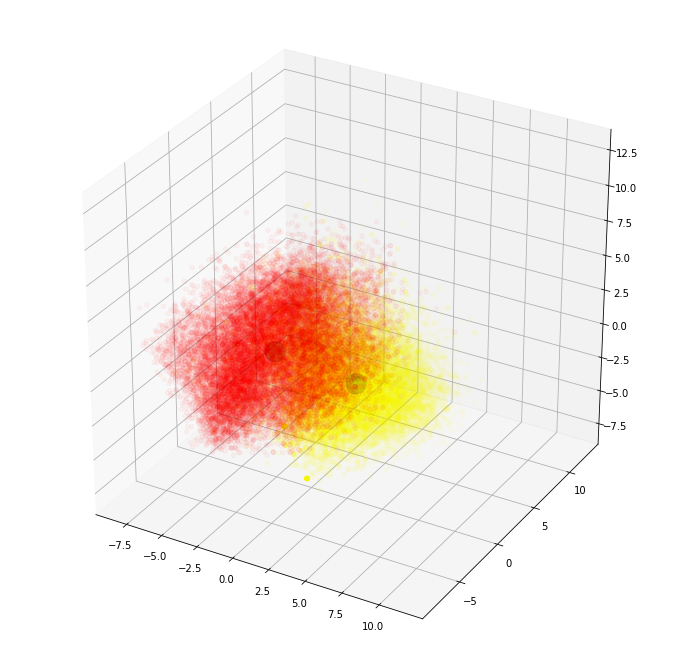

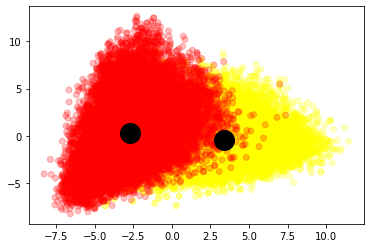

'# Define colors for each cluster \ncolors = [to_rgba("#FFFF00", 0.05) if i == 1 else to_rgba("#FF0000", 1)\n for i in joint_df["label"]]\n\n# 3D visualiztion\nfig = plt.figure(figsize=(12, 12))\nax = fig.add_subplot(projection=\'3d\')\n\n\nax.scatter(*pca_df, c=colors, alpha=0.035)\nax.scatter(*pca_centroids, c="black", s=400)\nplt.show()\n\n# 2D visualiztion - use only the first 2 dimesions\nplt.scatter(*pca_df[:2], c=colors)\nplt.scatter(*pca_centroids[:2], c="black", s=400)\nplt.show()'

In [ ]:
# Implement here
possible_colors = ["#FFFF00", "#FF0000", '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def visualize_data(real_labels, df, centoids, clusters_number):
  
  # Transpose matrix for scatter function - we get a list for each dimension
  tranposed_df = df.T
  # Transpose centroids for the same reason
  tranposed_centoids = centoids.T

  # Define colors for each cluster 
  colors = [to_rgba(possible_colors[k], 0.25) for k in range(clusters_number) for i in real_labels if i == k]
  """colors = [to_rgba("#FFFF00", 0.05) if i == 1 else to_rgba("#FF0000", 1)
  for i in real_labels]"""

  # 3D visualiztion
  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection='3d')


  ax.scatter(*tranposed_df[:3], c=colors, alpha=0.035)
  ax.scatter(*tranposed_centoids[:3], c="black", s=400)
  plt.show()

  # 2D visualiztion - use only the first 2 dimesions
  plt.scatter(*tranposed_df[:2], c=colors)
  plt.scatter(*tranposed_centoids[:2], c="black", s=400)
  plt.show()


# For any k, using PCA with any i > k components will lead to the same first k PCs
# This is why we can use PCA with n_components=3 and use the first two PCs for 2D visualiztion
pca = PCA(n_components=3)

# Transform data into the reduced dimension
pca_df = pca.fit_transform(scaled_df)

# Transform centroids
pca_centroids = pca.transform(k_means_alg.cluster_centers_)

visualize_data(joint_df["label"], pca_df, pca_centroids, 2)

"""# Define colors for each cluster 
colors = [to_rgba("#FFFF00", 0.05) if i == 1 else to_rgba("#FF0000", 1)
 for i in joint_df["label"]]

# 3D visualiztion
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


ax.scatter(*pca_df, c=colors, alpha=0.035)
ax.scatter(*pca_centroids, c="black", s=400)
plt.show()

# 2D visualiztion - use only the first 2 dimesions
plt.scatter(*pca_df[:2], c=colors)
plt.scatter(*pca_centroids[:2], c="black", s=400)
plt.show()"""

## 4. Performance evaluation (15 points)
### How did our clustering perform against the real labels?

We do have the true lables (fake/real), but we don't know which cluster correspond to which label. Therefore, we check the two options:

*   Define cluster 1 as fake and cluster 2 as real. What is the accuracy?
*   Define cluster 1 as true and cluster 2 as fake. What is the accuracy?

In [ ]:
# Implement here

# Calculate manually 
def calc_accuracy(real_labels, predicted_labels):
  count = 0
  for i in range(len(predicted_labels)):
    if predicted_labels[i] == real_labels[i]: # correct prediction
      count += 1

  return count / len(predicted_labels) # correct / total

# since calc_accuracy compares to the real labels (fake=0 and true=1), the 
# first cluster(0) is considered as fake and the second(1) is considered as true
print("our accuracy score, first cluster=fake, second cluster=true:",
      calc_accuracy(joint_df["label"], k_means_alg.labels_))
# flip clusters - first cluster (0) is considered as true and second cluster (1) is considered as fake
print("our accuracy score, first cluster=true, second cluster=fake:",
      calc_accuracy(joint_df["label"], 1 - k_means_alg.labels_))

# Alternatively, we can use sklearn accuracy_score function
print("sklearn accuracy score, first cluster=fake, second cluster=true:", 
      accuracy_score(joint_df["label"], k_means_alg.labels_))
print("sklearn accuracy score, first cluster=true, second cluster=false:",
      accuracy_score(joint_df["label"], 1 - k_means_alg.labels_))



our accuracy score, first cluster=fake, second cluster=true: 0.8705064813577442
our accuracy score, first cluster=true, second cluster=fake: 0.12949351864225578
sklearn accuracy score, first cluster=fake, second cluster=true: 0.8705064813577442
sklearn accuracy score, first cluster=true, second cluster=false: 0.12949351864225578


## 5. Find optimal `k` (10 points)
What is the best k for clustering?

* Cluster using a range of `k` (up to 20) and compare the SSD and the Silhouette values for every k.
* Plot SSD vs. k and Silhouette score vs. k.

Notes:
* You can get the SSD of a clustering using the `inertia_` attribute of the model.
* Silhouette score using `silhouette_score` function from `sklearn.metrics`. This function accept the model and the data.
* Computing Silhouette may takes long time. Estimate the Silhouette using a sample of 300 samples uisng the argument `sample_size=300`.

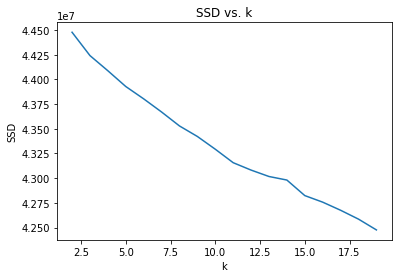

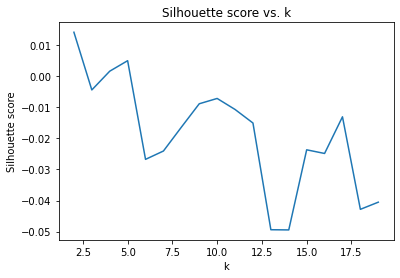

In [ ]:
# Implement here
def find_optimal_k(df, first_k, last_k, silhouette_sample_size):
  k_values = list(range(first_k, last_k))
  silhouette_list = []
  ssd_list = []

  # cluster using k from 2 to 20 (not inclusive)
  for k in k_values:
    k_means_alg = KMeans(n_clusters=k)
    k_means_alg.fit(df)

    ssd_list.append(k_means_alg.inertia_)
    silhouette_list.append(silhouette_score(df, k_means_alg.labels_, sample_size=silhouette_sample_size))

  # Plot SSD vs. k
  plt.plot(k_values, ssd_list)
  plt.xlabel('k') 
  plt.ylabel('SSD') 
  plt.title("SSD vs. k")
  plt.show()

  # Plot Silhouette score vs. k
  plt.plot(k_values, silhouette_list)
  plt.xlabel('k') 
  plt.ylabel('Silhouette score') 
  plt.title("Silhouette score vs. k")
  plt.show()

"""k_values = list(range(2, 20))
silhouette_list = []
ssd_list = []

# cluster using k from 2 to 20 (not inclusive)
for k in k_values:
  k_means_alg = KMeans(n_clusters=k)
  k_means_alg.fit(scaled_df)

  ssd_list.append(k_means_alg.inertia_)
  silhouette_list.append(silhouette_score(scaled_df, k_means_alg.labels_, sample_size=300))

# Plot SSD vs. k
plt.plot(k_values, ssd_list)
plt.xlabel('k') 
plt.ylabel('SSD') 
plt.title("SSD vs. k")
plt.show()

# Plot Silhouette score vs. k
plt.plot(k_values, silhouette_list)
plt.xlabel('k') 
plt.ylabel('Silhouette score') 
plt.title("Silhouette score vs. k")
plt.show()"""

find_optimal_k(scaled_df, 2, 20, 300)

### 6. What is the optimal k for clustering? (10 points)

* Explain.
* If optimal k!=2 what can be a good explanation for this?

The optimal k for clustering is 2.
as said in the lecture, for each sample:

ai = average distance from the sample to all data points in the same cluster

bi = average distance from the sample to all data points in the closest
cluster

s(i) = (bi - ai) / max(bi, ai)

Hence: high Silhouette score (close to 1) means that the distance from the sample to other samples in that cluster is small, and the distance from the sample to samples in other clusters is high. This is good clustering. Low Silhouette score (close to -1) means that the samples are closer to other clusters than to their clusters (bad clustering). 

So, we want to achieve the highest Silhouette score, and therefore we will choose k=2 as can be seen from the graph Silhouette score vs. k above

In addition, we cannot see a convincing "elbow" shape in the SSD vs. k graph. k = 2 sounds like a reasonable choice, because this is the first possible option for choosing k. 



# 7. PCA then k-means (10 points)

1.   List item
2.   List item


This time, lets try to change the order.
1. Generate TF-IDF 1000 features
2. Run PCA (using all dimenssions)
3. Run k-means
4. Plot 2D and 3D scatter plots
5. Estimate the accuracy according to true labels.
6. Explain how is it compared to the previous approach, where clustering is performed w/o PCA.

Note:
* When you compute the PCA, don't limit to first PCs, but use all of them.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


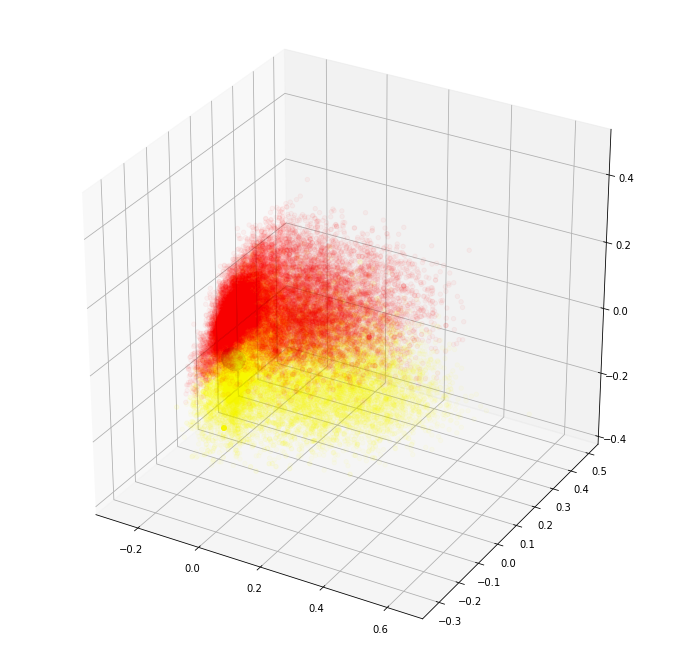

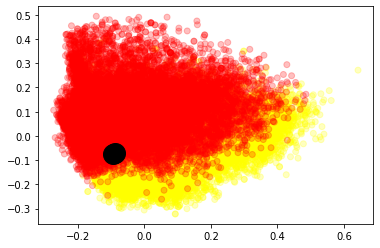

first cluster=fake, second cluster=true: 0.5814512895897367
first cluster=true, second cluster=fake: 0.41854871041026326


In [ ]:
tf_idf_df = generate_tf_idf_features(joint_df["text"])

pca = PCA()
transformed_data = pca.fit_transform(tf_idf_df)

# apply k-Means with 2 clusters on the scaled data
k_means_alg = KMeans(n_clusters=2)
k_means_alg.fit(transformed_data)

pca_centroids = pca.transform(k_means_alg.cluster_centers_) # Transform centroids

visualize_data(joint_df["label"], transformed_data, pca_centroids, 2)

# first cluster(0) is considered as fake and the second(1) is considered as true
print("first cluster=fake, second cluster=true:",
      calc_accuracy(joint_df["label"], k_means_alg.labels_))
# flip clusters - first cluster (0) is considered as true and second cluster (1) is considered as fake
print("first cluster=true, second cluster=fake:",
      calc_accuracy(joint_df["label"], 1 - k_means_alg.labels_))

# MNIST clustering (10 points)
Redo the same analysis, but this time using the MNIST data set. Notice that this time there are actually 10 'true' clusters.

1. What is the accuracy of the clustering when using k=10? \\
   * When for computing the accuracy of 10 classes, first you need to define what is the label of each cluster. Do that by majority votes. In theory, you may get two or more clusters with the same labels. We will ignore that for now. Meaning that you don't need to bother in case there are two clusters with the same label according to the majority vote. Simply count what is the fraction of 'other' digits in each cluster.
2. What is the optimal k?
3. How do the results changes if you first run PCA?

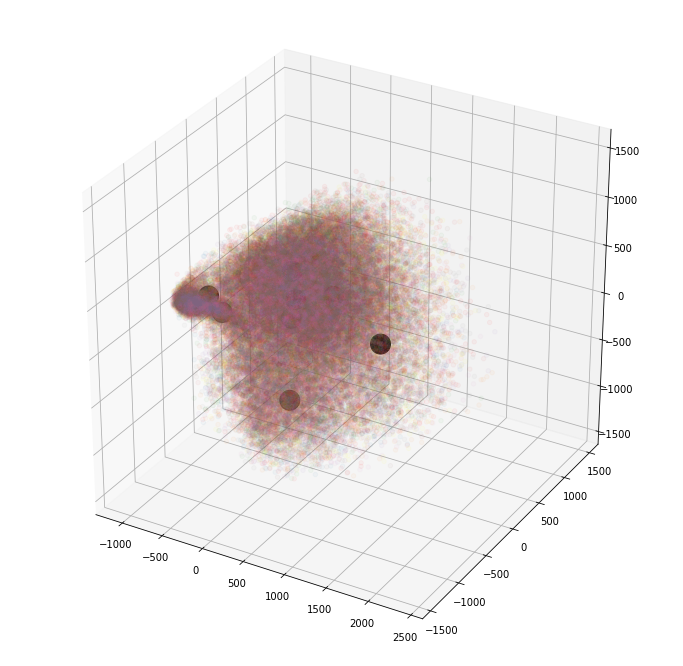

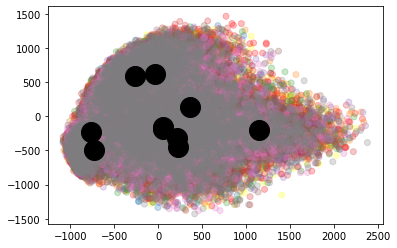

The accuracy score with PCA after:
0.5849428571428571


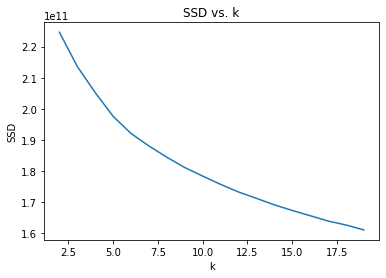

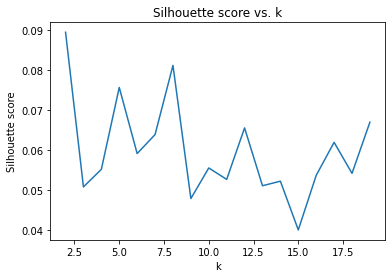

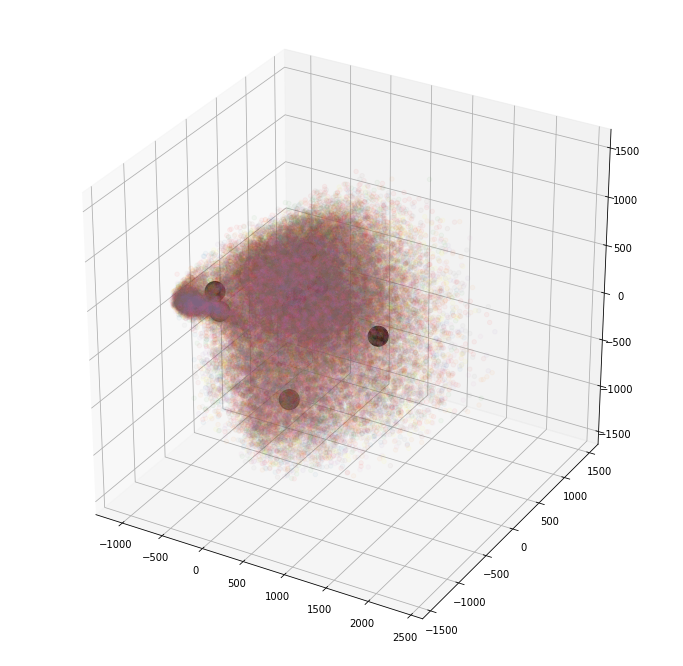

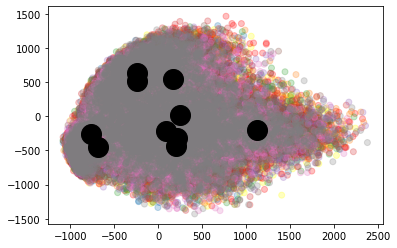

The accuracy score with PCA before:
0.5799285714285715


In [ ]:
import numpy as np

# notice that we don't need to scale the data beacause all the features values are 0 or 1.

def load_mnist_data():
  (train_X, train_y), (test_X, test_y) = mnist.load_data()

  X = np.concatenate((train_X, test_X), axis=0)
  y = np.concatenate((train_y, test_y), axis=0)

  # change each sample to one vector instead of matrix
  X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
  return X,y


def label_clusters_by_majority_of_votes(y, clustering_labels):
  k_means_labels = np.zeros(y.shape, dtype=np.uint8)
  for i in range(10):
    # get indecis of the current cluster
    indices_current_cluster = np.where(clustering_labels == i)
    # choose majority of votes of real labels to define the cluster label
    majority_of_votes = np.bincount(y[indices_current_cluster]).argmax()

    # save chosen label for each sample in the cluster
    k_means_labels[indices_current_cluster] = majority_of_votes
  return k_means_labels


### 1) Calculate accuracy when PCA performed after KMeans ###
X,y = load_mnist_data()

# apply k-Means with 10 clusters
k_means = KMeans(n_clusters=10)
k_means.fit(X)
k_means_labels = label_clusters_by_majority_of_votes(y, k_means.labels_)

# apply PCA
pca = PCA()
# Transform data into the reduced dimension
pca_df = pca.fit_transform(X)
# Transform centroids - SHOULD CHANGE COLOR
pca_centroids = pca.transform(k_means.cluster_centers_)
visualize_data(y, pca_df, pca_centroids, 10)

print("The accuracy score with PCA after:")
print(calc_accuracy(y, k_means_labels))

### 2) The optimal K ###
find_optimal_k(X, 2, 20, 300)


### 3) Calculate accuracy when PCA performed before KMeans ###
X,y = load_mnist_data()

# apply PCA
pca = PCA()
# Transform data into the reduced dimension
pca_df = pca.fit_transform(X)

# apply k-Means with 10 clusters
k_means = KMeans(n_clusters=10)
k_means.fit(X)
k_means_labels = label_clusters_by_majority_of_votes(y, k_means.labels_)
# Transform centroids - SHOULD CHANGE COLOR
pca_centroids = pca.transform(k_means.cluster_centers_)
visualize_data(y, pca_df, pca_centroids, 10)

print("The accuracy score with PCA before:")
print(calc_accuracy(y, k_means_labels))

1) The accuracy score of the clustering (with PCA after the KMeans algorithm) when using k = 10 is 0.5850285714285715.

2) Based on the "elbow" method the optimal k is k=5. We can see from the SSD vs. k graph that the oprimal K is 5, because before k=5 the slope is steep and after k=5 it is moderate.
However, based on the silhouette graph, k=2 is the optimal k. k=2 has the highest silhouette score, meaning that the distance from a sample to other samples in each cluster is small, and the distance from a sample to samples in other clusters is high. This is good clustering.

3) The accuracy score of the clustering (with PCA before the KMeans algorithm) when using k = 10 is 0.5807428571428571.

# Compute projection (10 points)
**Notice:** No code required in this section.

Given the next PCA projection matrix
$\begin{pmatrix}
1 & 1\\
2 & -1
\end{pmatrix}$
And the correspoding egienvalues
$(5, -1)$

Compute the projection to one dimension of the next two vectors:
\begin{pmatrix}
1 & 3
\end{pmatrix}
\begin{pmatrix}
3 & 7
\end{pmatrix}

In [ ]:
# Answer here and show your computations (no code)

The given projection matrix W is composed of 2 egienvectors.
In order to project the vectors into one dimension, we should take the egienvector that has the corresponding highest egienvalue, which is
$\begin{pmatrix}
1\\
2
\end{pmatrix}$.

Project $\begin{pmatrix}
1 & 3
\end{pmatrix}$:

 $\begin{pmatrix}
1 & 2
\end{pmatrix}$ * 
 $\begin{pmatrix}
1 \\ 3
\end{pmatrix}$ = 7

Project $\begin{pmatrix}
3 & 7
\end{pmatrix}$:

 $\begin{pmatrix}
1 & 2
\end{pmatrix}$ * 
 $\begin{pmatrix}
3 \\ 7
\end{pmatrix}$ = 17